<h1> Numpy Neural Network <h1>
<hr>

***Author: Jose Ignacio Gomez***

In this notebook we will try an implementation of a Neural Network using numpy library. 
The objective is to understand the deep architecture of a NN.
All of the code is based on the implementation made by Piotr Skalski https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb

## Imports

In [2]:
import numpy as np
from IPython.display import Image

## Architecture

![image.png](visualizations/nn_architecture.png)
**Figure 1**. Architecture of our network

## Initiation of the network

First of all, we need to initiate the different parameters, including the size and initial values of the layers, activation functions, number of layers...

In [3]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [4]:
#Initialize a layer with given structure
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        #Random matrix for layer weights 2x4
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1

        #Random vector for layer bias 1x4
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

        #The use of random small (*0.1) initial values increases efficiency
        
    return params_values

The activation functions we will use are the sigmoid and ReLU. We will need their derivatives, so we just define them as *function_backward*, in order to apply them at backprop time.
![image.png](visa)
**Figure 2**. Sigmoid activation function.

In [5]:
#Activation functions and its derivatives

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

## Forward propagation

Although nomenclature is not pretty straightforward, we will try to make it as clear as possible.

**W** will be the "weight" matrix, which will have the weights set for every input of the layer.

**A** will be the input of the current layer (output of the previous one)

**B** will be the biases vector.

**Z** will be the value of the next operation:
    $$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$
Finally we will apply the activation function g():
    $$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [7]:
# Single layer propagation. W * A + b
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # W * A + b
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

In [8]:
# Full forward propagation
# X : net input
# params_values : initial values for net parameters
# nn_architecture: architecture of the net
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {} # Dictionary to memorize data
    A_curr = X # result for each fwdprop. Input values at beginning
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

## Loss and cost function

For our purpose we will use the binary-crossentropy cost function J(W, b), which takes the average between the crossentropy loss functions *L($\hat{y}$,y)*.
    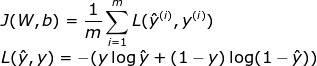

In [9]:
# Loss and cost functions
# We'll use cross-entropy loss function -(y*log(^y) + (1-y) * log(1-^y))

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

## Backpropagation

The concept of backpropagation is easy. We want to minimize our cost function, so we calculate its gradient respect each of the variables of the layer. Afterwards we want to move towards the opposite direction of the gradient, so we substract each part of the gradient to its respective variable.

So, per each layer, we will get:

Z_curr = Z_old - dZ

A_curr = A_old - dA

b_curr = b_old - db

W_curr = W_old - dW

In [10]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')


    # Derivatives we will apply for backprop
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr



def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        # history of gradients
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Updating parameters after backprop

In [20]:
# Now we got the values for the gradient, and we want to update our parameters
# in order to minimize our loss function. So our new parameters will be
# w_new = w - k * dL/dw, b_new = b - k * dL/db...
# Where k is the learning rate
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

## Taining function

In [13]:
# Finally! Training!

def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

# Hands on!

Now that we have our neural network ready to work, let's see it working.

## Imports and settings

In [14]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [15]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

## Create artificial dataset and plotting function

In [16]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [17]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()


## Visualization of the dataset

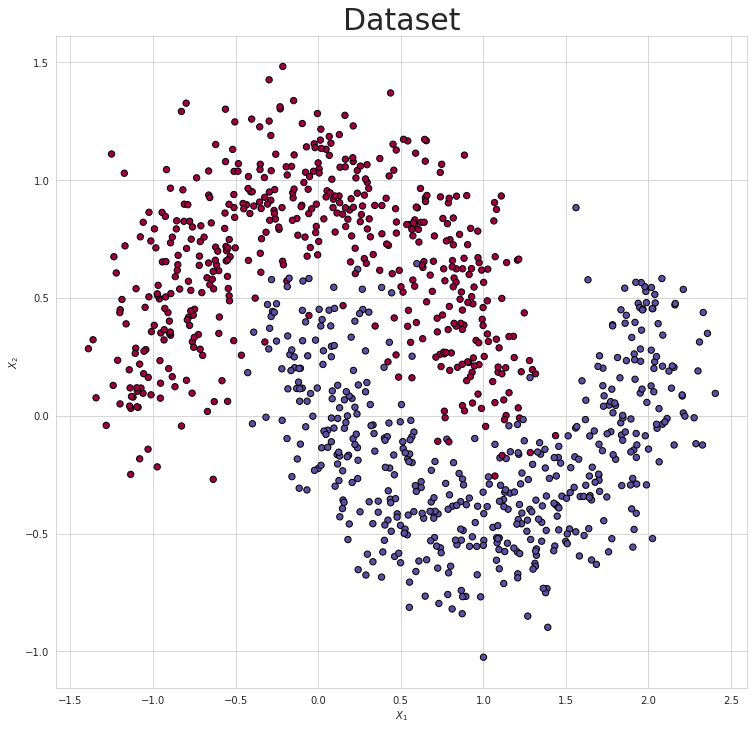

In [18]:
make_plot(X, y, "Dataset")

## Testing our model

In [21]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)

In [22]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [23]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - Numpy".format(acc_test))

Test set accuracy: 0.98 - Numpy


## Keras model

In [24]:
# Building a model
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=200, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [25]:
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Keras".format(acc_test))

Test set accuracy: 0.98 - Keras


# Visualization of the process

## Settings

In [36]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_visualizations/"

In [37]:
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

## Keras model

In [38]:
def callback_keras_plot(epoch, logs):
    plot_title = "Keras Model - It: {:05}".format(epoch)
    file_name = "keras_model_{:05}.png".format(epoch)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs)

In [39]:
# Adding callback functions that they will run in every epoch
testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=callback_keras_plot)

In [40]:

# Building a model
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=200, verbose=0, callbacks=[testmodelcb])

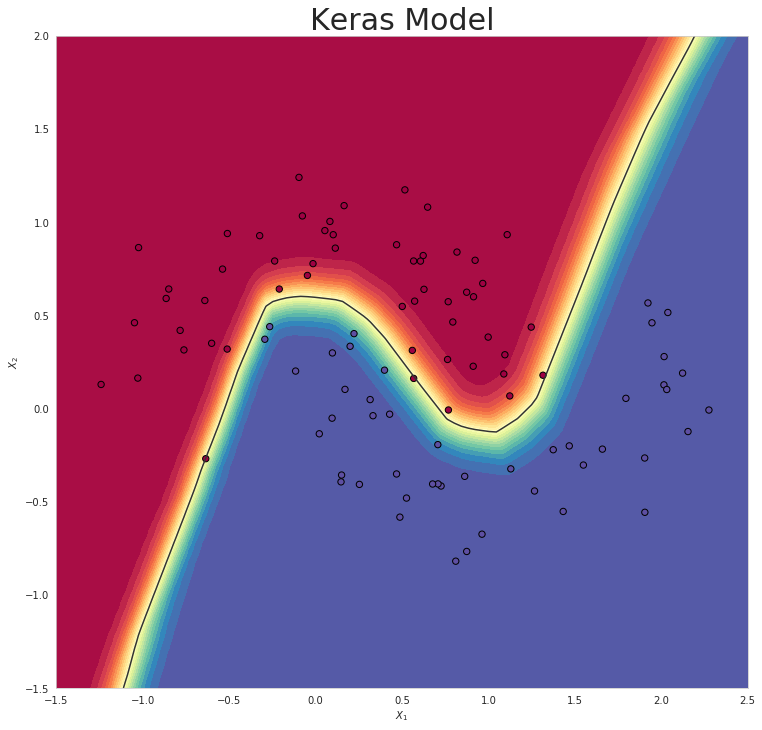

In [42]:
prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)
make_plot(X_test, y_test, "Keras Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs)

![Keras](visualizations/keras_visualization.gif "keras")

## Numpy model

In [43]:

def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [44]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, False, callback_numpy_plot)

/home/nacho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/home/nacho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/home/nacho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/home/nacho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/home/nacho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/home/nacho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels w

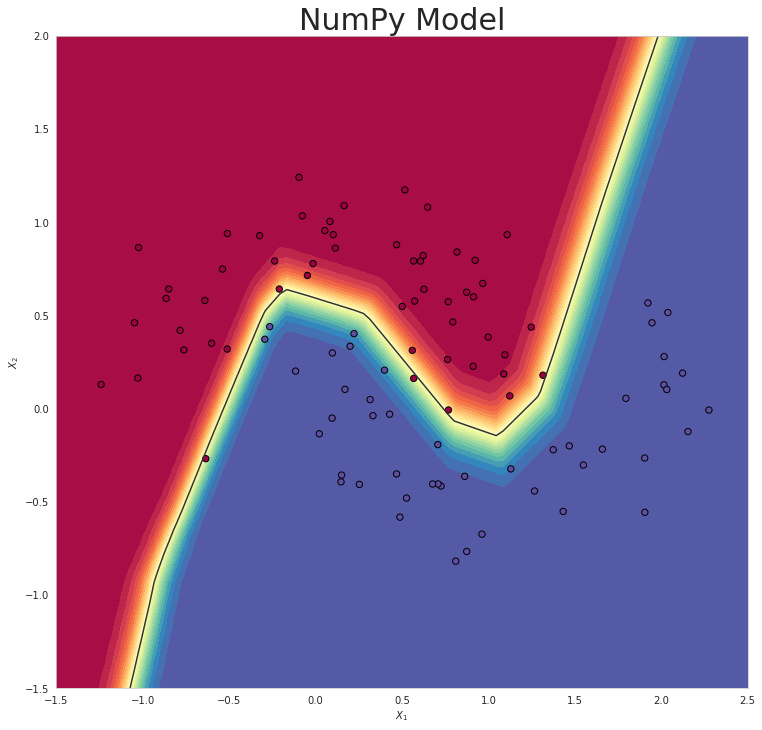

In [45]:

prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)

![Numpy](visualizations/numpy_visualization.gif "numpy")

# Creating our gif images

The last step will be to join every .png image created by the training processes above. For this purpose we will use the ImageMagic tool. So we open a console in Linux and type:
**convert -delay 1- -loop 0 keras_model* keras_visualization.gif**
And the same will work with the numpy model.